Графики для сравнения

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np

color_map = {
    'bayes': 'r',
    'gadma': 'g',
    'random_search': 'b',
}


def get_max_ll(model_file):
    dem_model = importlib.import_module(model_file.replace('/', '.').rstrip('.py'))
    return dem_model.__getattribute__('max_possible_ll')


def draw(data_dir):
    if 'results' not in os.listdir(data_dir):
        return

    results_dir = os.path.join(data_dir, 'results')
    last_start_dir = os.path.join(results_dir,
                                  sorted(os.listdir(results_dir))[-1])

    fig, ax = plt.subplots(figsize=(19.2, 10.8))
    fig.suptitle(data_dir)

    max_possible_ll = get_max_ll(os.path.join(data_dir, 'demographic_model.py'))

    max_line = plt.axhline(max_possible_ll, color='r', linestyle='--', linewidth=1)
    plot_lines = [max_line]
    label_names = ['max_possible_ll']

    max_iter_num = 0

    dirnames = next(os.walk(last_start_dir))[1]

    for algo_dir in dirnames:
        lls = []
        # ll_min = []
        # ll_max = []
        # ll_mean = []
        iter_num = 0
        cur_max_iter_num = 0
        avg_iter_num = (0, 0)

        for dirpath, _, files in os.walk(os.path.join(last_start_dir,
                                                      algo_dir)):
            for f in files:
                if f == 'evaluations.log':
                    log_file = os.path.join(dirpath, f)
                    with open(log_file) as file:
                        next(file)

                        cur_lls = []
                        for iter_num, line in enumerate(file):
                            parts = line.strip().split('\t')

                            logLL = -float(parts[1])
                            cur_max_ll = max(logLL, cur_lls[-1]) if cur_lls else logLL
                            cur_lls.append(cur_max_ll)

                            # if iter_num < len(ll_min):
                            #     ll_min[iter_num] = min(ll_min[iter_num], cur_max_ll)
                            # else:
                            #     ll_min.append(cur_max_ll)
                            #
                            # if iter_num < len(ll_max):
                            #     ll_max[iter_num] = max(ll_max[iter_num], cur_max_ll)
                            # else:
                            #     ll_max.append(cur_max_ll)
                            #
                            # if iter_num < len(ll_mean):
                            #     ll_mean[iter_num] = (ll_mean[iter_num][0] + cur_max_ll, ll_mean[iter_num][1] + 1)
                            # else:
                            #     ll_mean.append((cur_max_ll, 1))

                        lls.append(cur_lls)
                        cur_max_iter_num = max(cur_max_iter_num, iter_num + 1)
                        avg_iter_num = (avg_iter_num[0] + iter_num + 1, avg_iter_num[1] + 1)

        # print(list(zip(lls)))
        lls = np.array([*zip(*lls)]).T

        # ll_mean = [(sm / cnt) for (sm, cnt) in ll_mean]
        ll_mean = lls.mean(axis=0)

        # TODO: repeat(or special values) last iters if iter_num is different
        # iters = list(range(cur_max_iter_num))
        iters = list(range(lls.shape[1]))

        col = color_map[algo_dir]

        plot_lines.append(plt.plot(iters, ll_mean, color=col)[0])
        label_names.append(f'{algo_dir}: {avg_iter_num[0] / avg_iter_num[1]} avg iters')

        # confidence interval
        ci = 1.96 * np.std(lls, axis=0) / np.sqrt(lls.shape[0])
        # print(ll_mean)

        plt.fill_between(iters, (ll_mean - ci), (ll_mean + ci), alpha=0.4, color=col)

        # ll_min = lls.min(axis=0)
        # ll_max = lls.max(axis=0)
        # plt.fill_between(iters, ll_min, ll_max, alpha=0.1, color=col)

        max_iter_num = max(max_iter_num, cur_max_iter_num)

    #     ax.yaxis.set_major_formatter(major_formatter)
    plt.yscale('symlog')

    # iters = list(range(max_iter_num))
    # plt.xticks(iters)

    plt.yticks(list(filter(lambda x: x < max_possible_ll, plt.yticks()[0])) + [int(max_possible_ll)])
    # print(plt.yticks())
    # plt.yticks(plt.yticks()[0], plt.yticks()[1][:-1] + [f'~ {int(max_possible_ll)}'])

    plt.xlabel('Iteration')
    plt.ylabel('LogLL')

    # plt.ylim(-4000 - 100, -3000 + 100)

    plt.legend(plot_lines, label_names)

    plt.savefig(os.path.join(last_start_dir, 'Comparison2'))

<IPython.core.display.Javascript object>


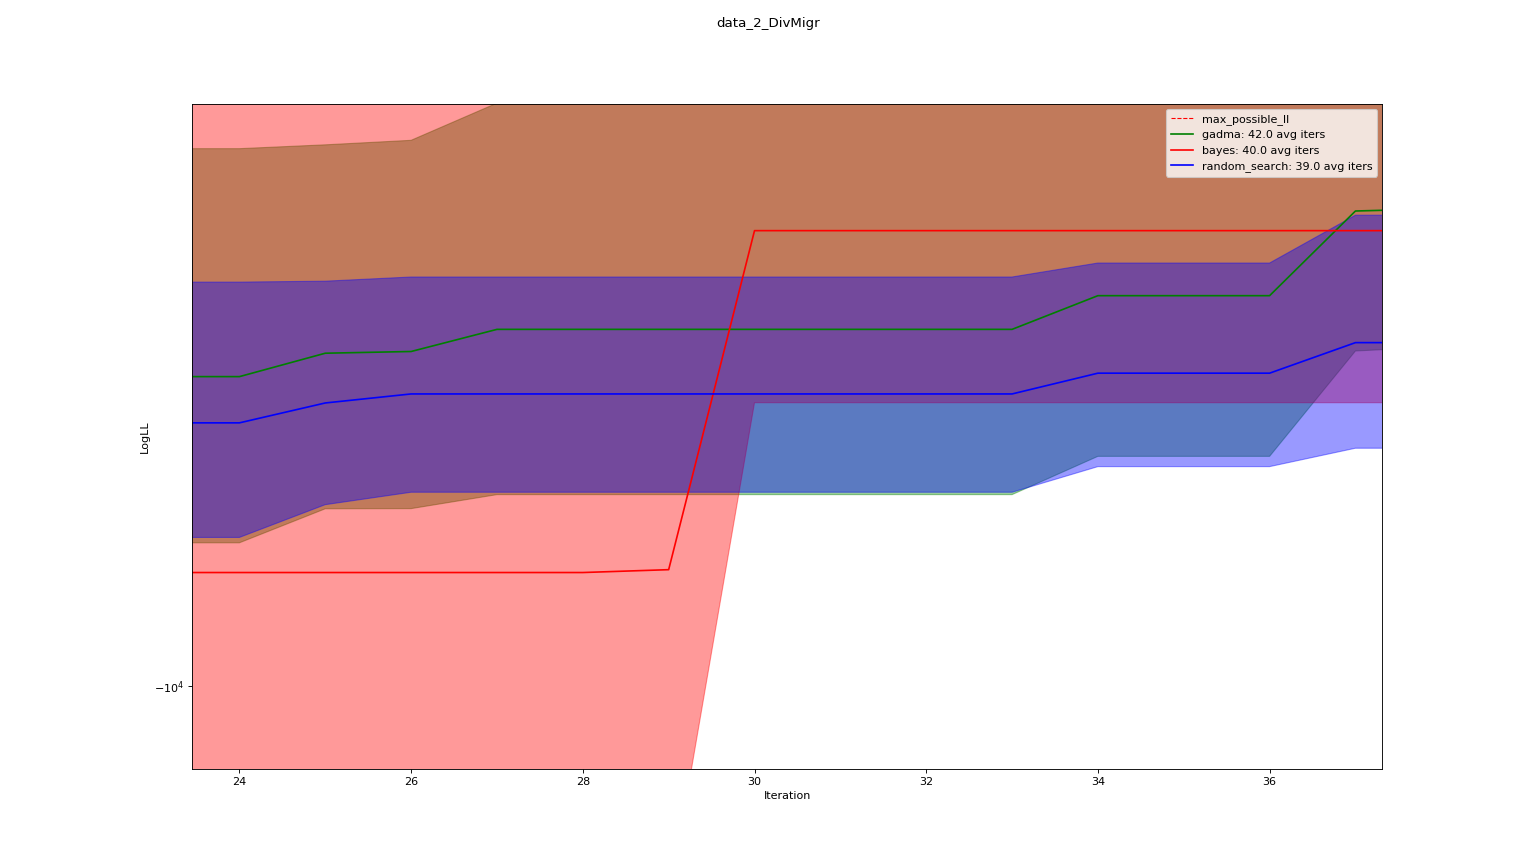

<IPython.core.display.Javascript object>


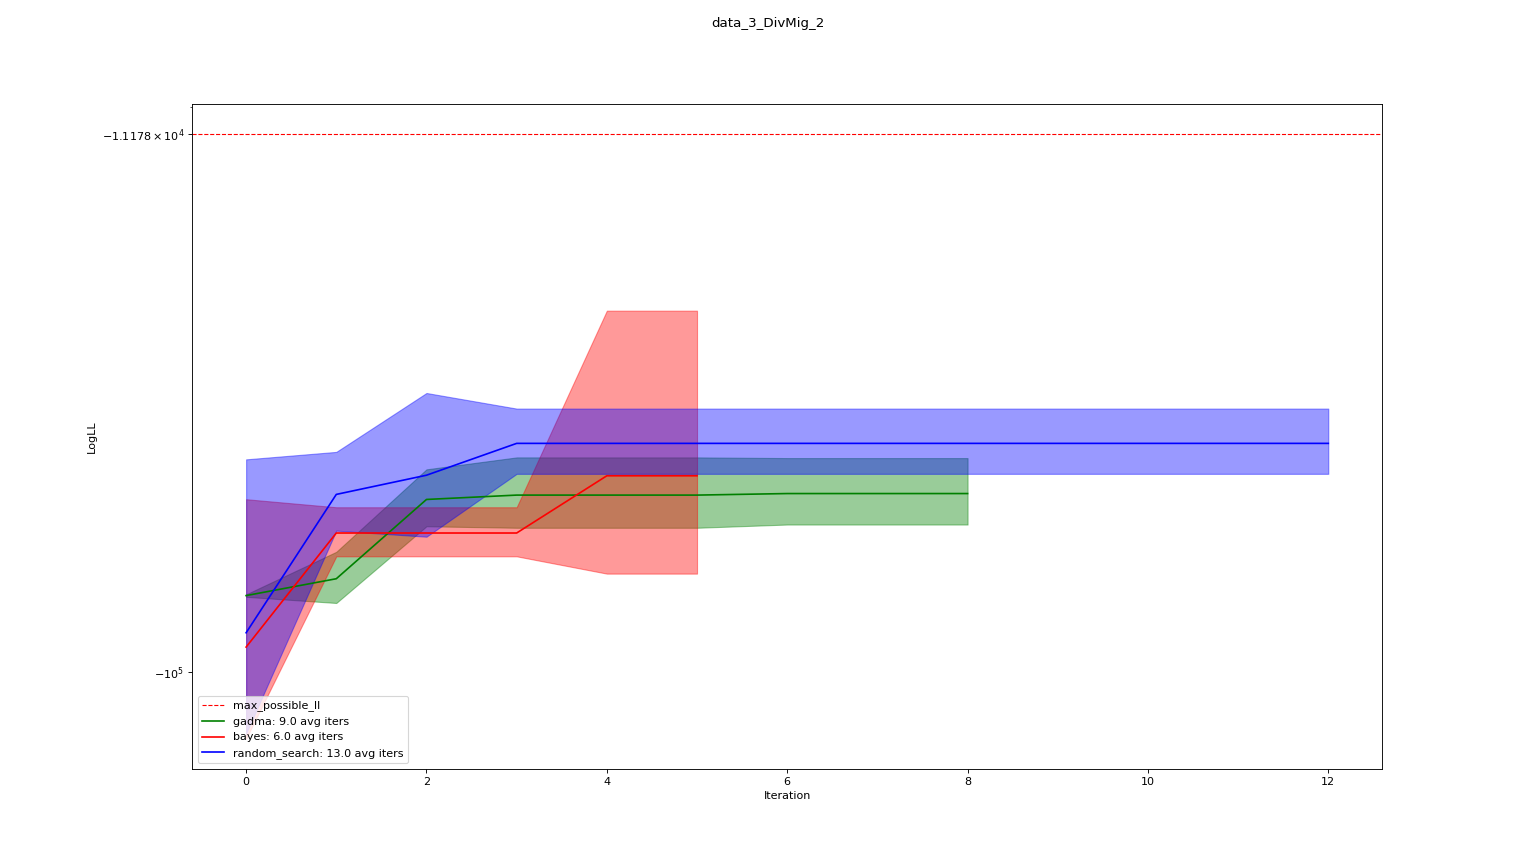

<IPython.core.display.Javascript object>


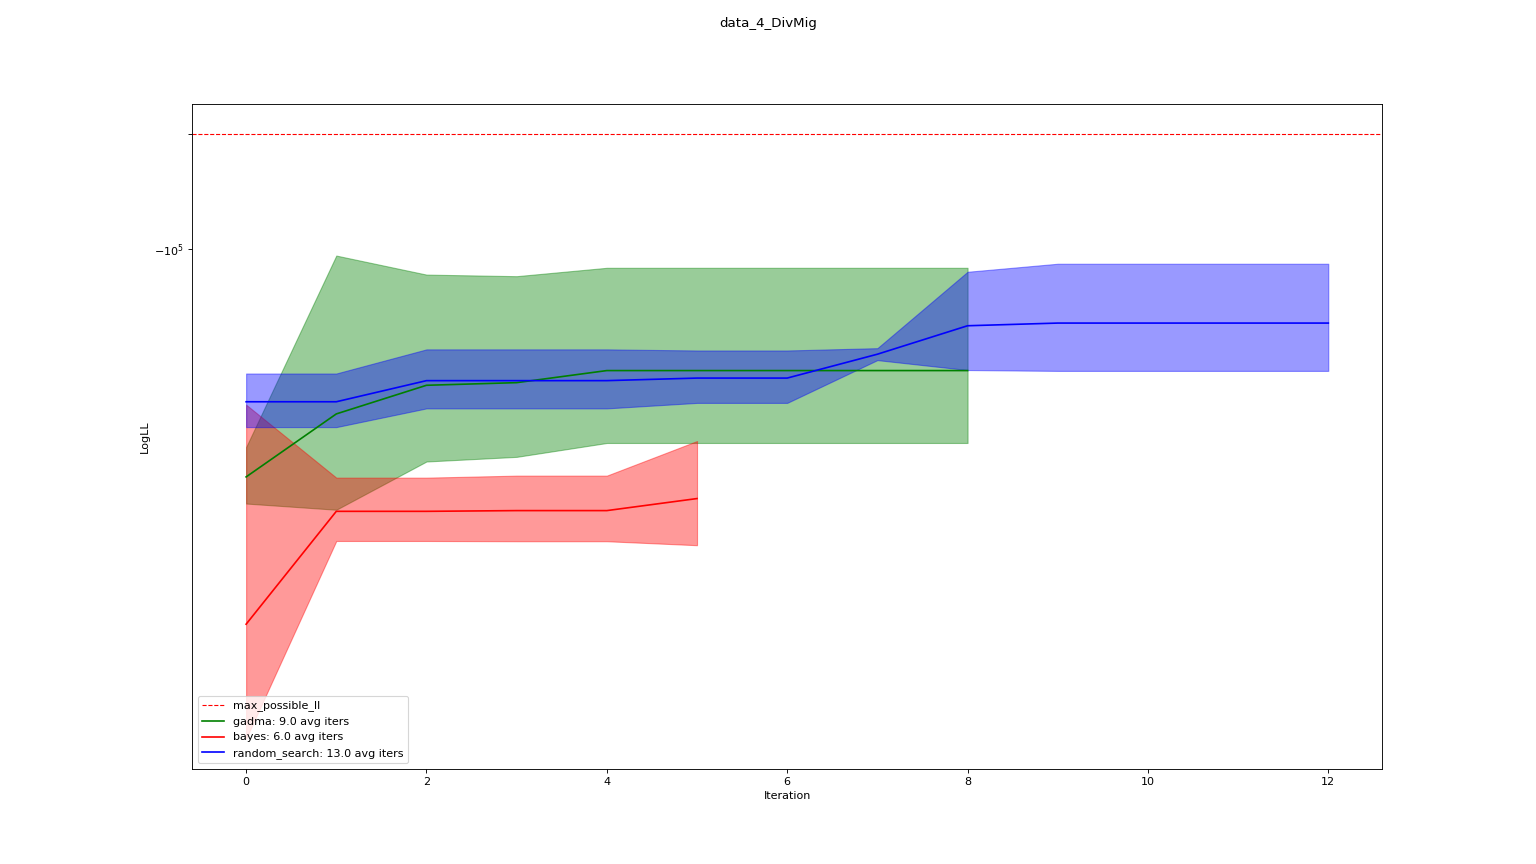

[None, None, None]

In [3]:
%matplotlib notebook
data_dirs = list(filter(lambda x: x.startswith('data'), next(os.walk('.'))[1]))
[draw(d_d) for d_d in data_dirs]